# Experimentation and Evaluation - Assignment 2
## Experiment: camelCase vs kebab-case

Import the required libraries.

In [1]:
import json

# import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

Load the results from the json file containing the experiment data.
Cluster all the data into its question object to be cleanly and correctly plotted.

In [32]:
# get raw data from json
json_data: dict
with open("data.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)

# cluster questions data structure skeleton
NUM_QUESTIONS = 33
NUM_WARMUP = 3
cluster_questions: dict[str, dict] = {}
for i in range(NUM_QUESTIONS):
    cluster_questions[f"question_{i+1}"] = {
        "is_kebab": False,
        "samples": [],
        "df": pd.DataFrame(),
        "df_zscore": pd.DataFrame(),
    }

# populate clusters with user samples
for user_sample in json_data:
    for i, q in enumerate(user_sample["questions"]):
        cluster_questions[f"question_{i+1}"]["samples"].append(q)

# get dataframe and timer z-score per question
for _, v in cluster_questions.items():
    v["df"] = pd.DataFrame(v["samples"])
    v["is_kebab"] = "-" in v["df"].correct_word[0]
    v["df_zscore"] = v["df"][["timer"]].apply(st.zscore)

### Data categorization

to prepare for data analysis and inferential statistics, we need to categorize questions into their types and difficulty length

- short: 2 words => 5 camel, 5 kebab case
- medium: 4 words => 6 camel, 4 kebab case
- long: 6 words => 6 camel, 4 kebab case 

Notice that the difficulty increases by +2 words each test case.

I use 2 separate dataframes for camel and kebab case to make it easier to plot and analyze the data.

Each dataframe is filtered by:
- mental chronometry: time > 200ms is expected for the result to be considered valid, see [References](README.md)
- wrong answers: only correct answers are considered valid, otherwise the timing spent to click the right answer create noise

In [33]:
# remember first 3 questions are warmup
TEST_CASES = {
    "short": {"kebab": [4, 8, 10, 11, 12], "camel": [5, 6, 7, 9, 13]},
    "medium": {"kebab": [18, 20, 21, 22], "camel": [14, 15, 16, 17, 19, 23]},
    "long": {"kebab": [29, 30, 32, 33], "camel": [24, 25, 26, 27, 28, 31]},
}


def filter_mental_chronometry(df: pd.DataFrame):
    """filter out mental chronometry outliers"""
    return df[df["timer"] > 200]


def filter_wrong_answers(df: pd.DataFrame):
    """filter out wrong answers"""
    return df[df["wrongs"].apply(lambda x: len(x) == 0)]


many_words_kebab = pd.concat(
    [
        cluster_questions[f"question_{index}"]["df"]
        for cases in TEST_CASES.values()
        for index in cases["kebab"]
    ]
)

many_words_kebab = filter_mental_chronometry(many_words_kebab)
many_words_kebab = filter_wrong_answers(many_words_kebab)

many_words_camel = pd.concat(
    [
        cluster_questions[f"question_{index}"]["df"]
        for cases in TEST_CASES.values()
        for index in cases["camel"]
    ]
)

many_words_camel = filter_mental_chronometry(many_words_camel)
many_words_camel = filter_wrong_answers(many_words_camel)

Compute z-score: with libraries that encapsulate the translation into a normal distribution and then into a standard distribution to get results with a mean of 0 and a standard deviation of 1.

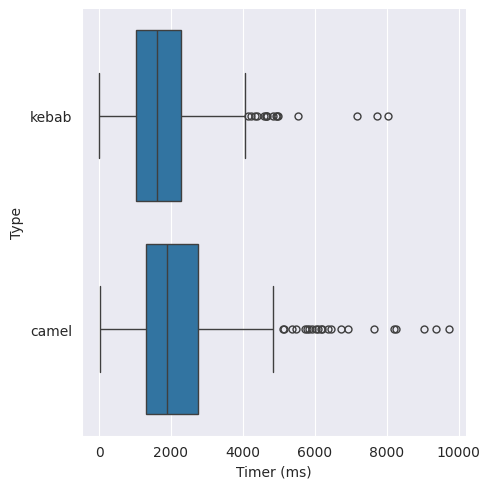

In [34]:
tmp = pd.DataFrame()
for q in cluster_questions.values():
    tmp2 = q["df"].copy()
    tmp2["is_kebab"] = "kebab" if q["is_kebab"] else "camel"
    tmp = pd.concat([tmp, tmp2])

g = sns.catplot(data=tmp, x="timer", y="is_kebab", kind="box")
g.set_ylabels("Type")
g.set_xlabels("Timer (ms)")

### Hypothesis evaluation

![t-distribtion formula](figures/t-distribution.png)

 
Significance level $\alpha$ is set to 0.05.

**Null hypothesis $H_0$ is rejected**: 
p-value < $\alpha$, so the difference in means is statistically significant.
Meaning, we reject the Null Hypothesis $H_0$.

In [35]:
kebab_timers = many_words_kebab["timer"]
camel_timers = many_words_camel["timer"]
res_stat = st.ttest_ind(kebab_timers, camel_timers)
print(res_stat)

TtestResult(statistic=-3.5557267830911563, pvalue=0.0004041768826528386, df=653.0)


Confirm hypothesis


Plot the raw results


In [ ]:
q32 = cluster_questions["question_32"]
print(q32["is_kebab"])
sns.catplot(data=q32["df"], x="timer", jitter=True)

q31 = cluster_questions["question_31"]
print(q31["is_kebab"])
# sns.catplot(data=cluster_questions['question_31']['df'],
# x='timer',  kind='violin', color='.9', inner=None)
# sns.swarmplot(data=cluster_questions['question_31']['df'], x='timer')
sns.catplot(data=q31["df"], x="timer", jitter=True)
# cr_mean = np.nanmean(df.CreditScore.values.tolist())
# cr_std = np.nanstd(df.CreditScore.values.tolist())
# print("Mean Credit Score is: ", cr_mean)
# print("Std Credit Score is: ", cr_std)